In [194]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

nx = 9 #The number of inside corners in x
ny = 6 #The number of inside corners in y

def get_corners(fname, nx, ny, criteria):
    '''
    us cv2 to find the corners of chess board pattern
    '''
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret:
        corners = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
    
    return ret, corners

def display_corners(fname, nx, ny, corners):
    '''
    display a plot of the image with a color overlay of the found corners
    '''
    img = cv2.imread(fname)
    
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, True)

    plt.title(fname)
    plt.imshow(img)

    
def calib(image_path, nx, ny):
    '''
    take an image_path which is a mask to collect images
    nx is the number of expected corners along X axis
    ny is the number of expected corners along Y axis
    returns a camera mtx
    '''
    show_imgs = False
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Make a list of calibration images
    cal_files = glob.glob(image_path)
    
    img = cv2.imread(cal_files[0])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    imgpoints =[]
    objpoints = []

    if show_imgs:
        plt.rcdefaults()
        fig = plt.figure(figsize=(10,30))

    n = 0
    for fname in cal_files:
        ret, corners = get_corners(fname, nx, ny, criteria)
        
        if show_imgs:
            plt.subplot(10,2, n+1)
            
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            if show_imgs:
                display_corners(fname, nx, ny, corners)
        else:
            if show_imgs:
                img = cv2.imread(fname)
                plt.title('failed:' + fname)
                plt.imshow(img)

        n += 1

    if show_imgs:
        plt.show()
    
    dim = gray.shape[::-1]
    
    err, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                                objectPoints=objpoints, 
                                imagePoints=imgpoints, 
                                imageSize=dim, 
                                cameraMatrix=None, 
                                distCoeffs=None)
    
    print('re-projection error', err)
    
    return mtx, dist


#call the calibration function with the camera_cal dir
mtx, dist = calib('camera_cal/*.jpg', nx, ny)


re-projection error 0.8457746366205736


In [2]:
print(cv2.__version__)
print(mtx)
print(dist)

3.2.0
[[  1.15694047e+03   0.00000000e+00   6.65948815e+02]
 [  0.00000000e+00   1.15213880e+03   3.88784787e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.37638054e-01  -8.54042210e-02  -7.90999421e-04  -1.15882399e-04
    1.05726095e-01]]


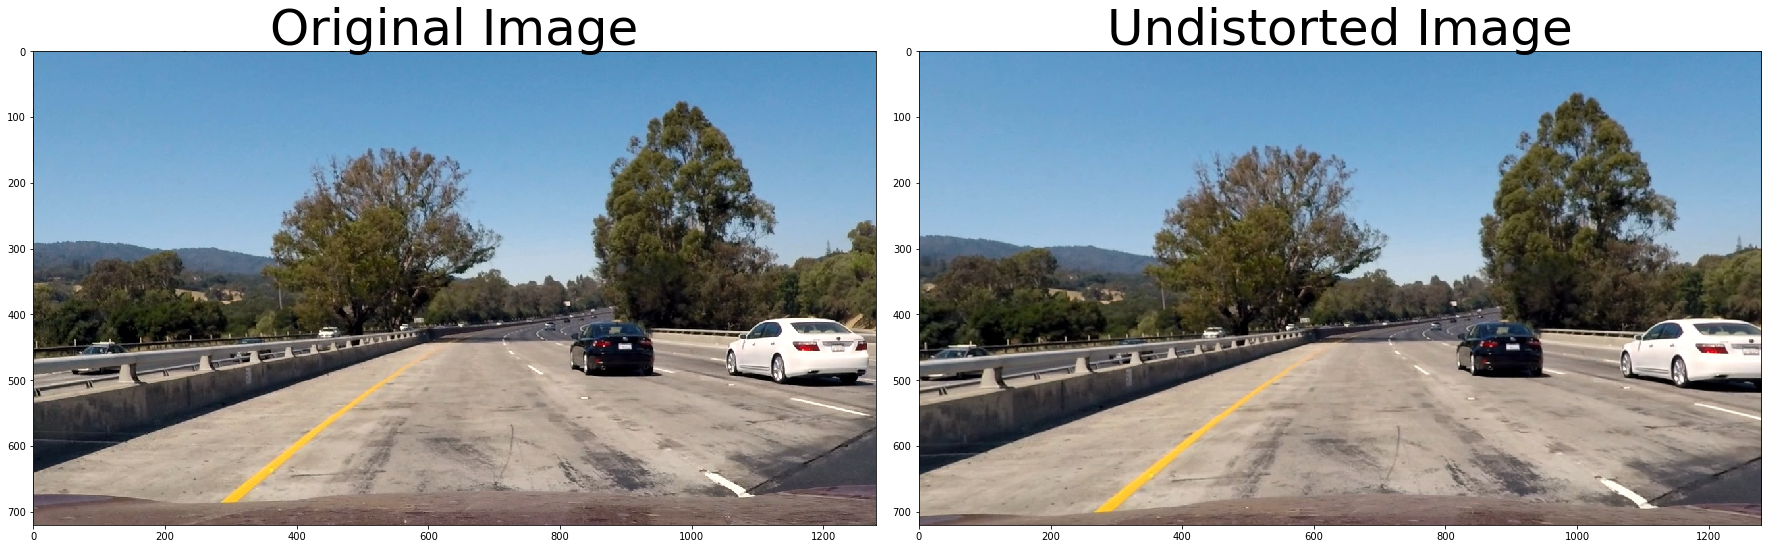

In [3]:
# Undistort image

def undistort(img, mtx, dist):
    '''
    Takes an image and camera maxtrix and distance coeffcients
    returns the undistorted image
    '''
    new_image = cv2.undistort(src=img, cameraMatrix=mtx, distCoeffs=dist)
    
    return new_image


# Read in an image
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted = undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

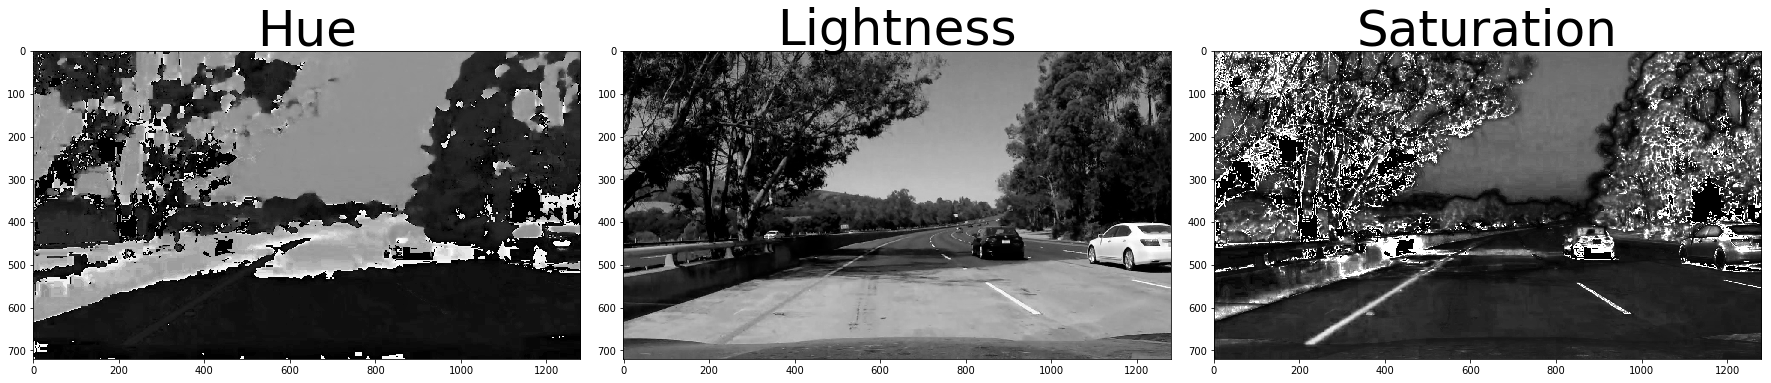

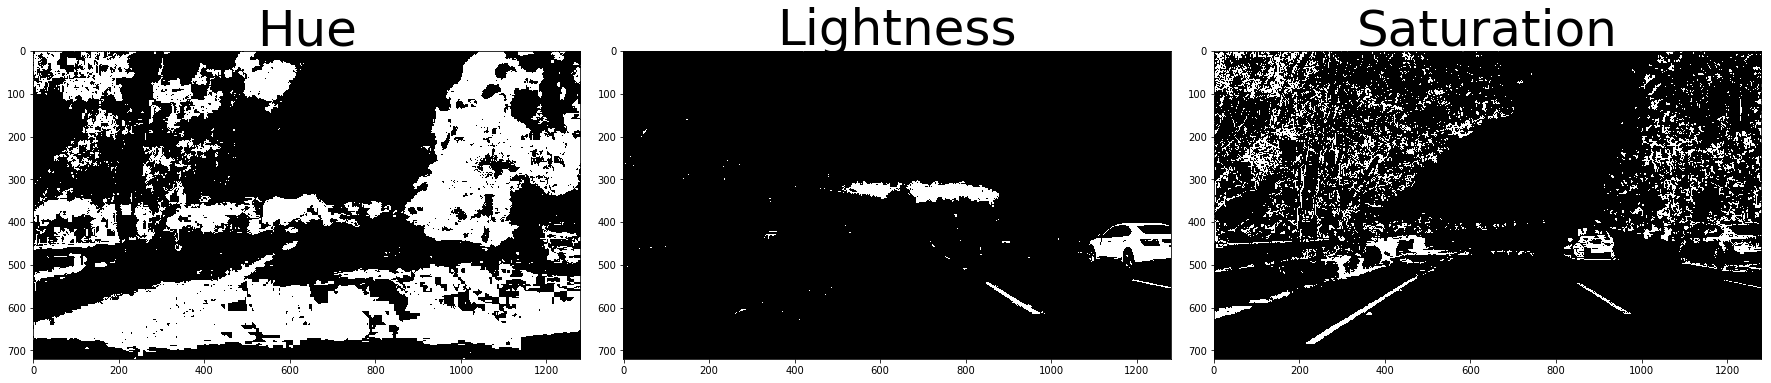

In [120]:

img = cv2.imread('test_images/test5.jpg')

'''
HLS Thresholding
'''

hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
H, L, S = cv2.split(hls)


def display_three_channels(channels, labels):
    f, subplt = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    for i in range(3):
        subplt[i].imshow(channels[i], cmap='gray')
        subplt[i].set_title(labels[i], fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def thresh_mask(img, thresh, val=0.1):
    flt_img = np.zeros_like(img, dtype=float)
    flt_img[(img > thresh[0]) & (img <= thresh[1])] = val
    return flt_img

channel_labels = ("Hue", "Lightness", "Saturation")

display_three_channels((H, L, S), channel_labels)

thresh = (10, 30)
H = thresh_mask(H, thresh)

thresh = (150, 255)
S = thresh_mask(S, thresh)

thresh = (190, 255)
L = thresh_mask(L, thresh)

display_three_channels((H, L, S), channel_labels)


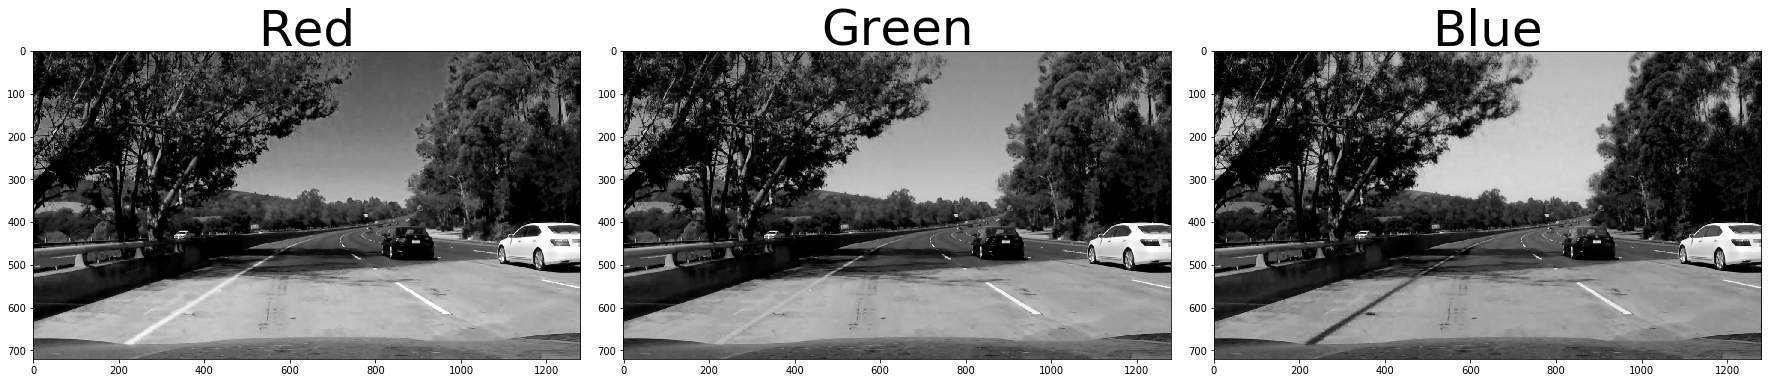

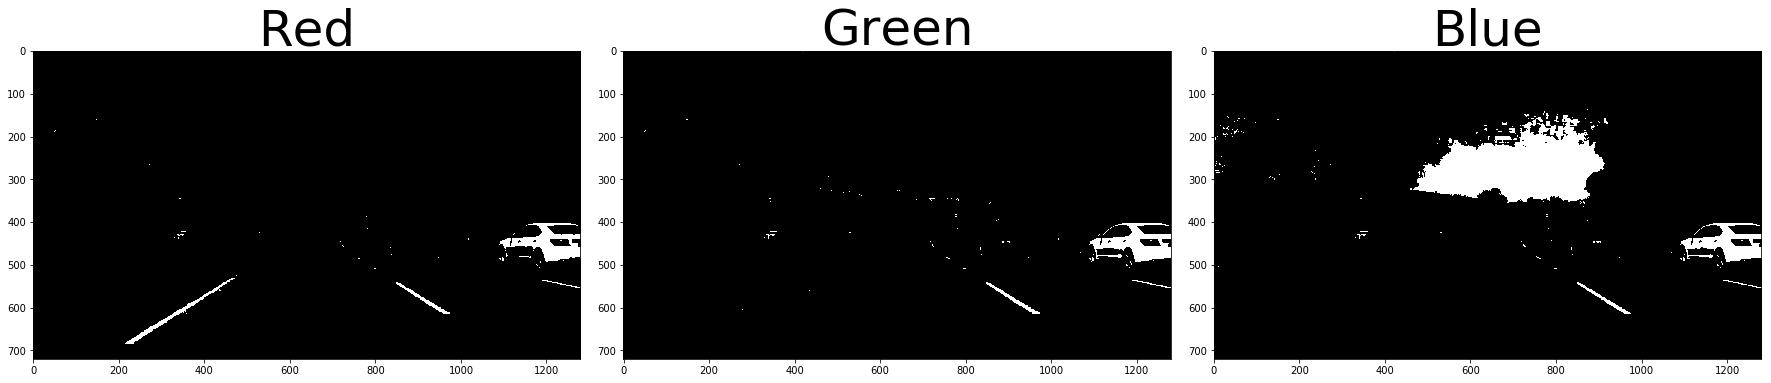

In [121]:
'''
RGB Thresholding
'''

rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
R, G, B = cv2.split(rgb)

channel_labels = ("Red", "Green", "Blue")

display_three_channels((R, G, B), channel_labels)

thresh = (220, 255)
R = thresh_mask(R, thresh)

thresh = (200, 255)
G = thresh_mask(G, thresh)

thresh = (200, 255)
B = thresh_mask(B, thresh)

display_three_channels((R, G, B), channel_labels)


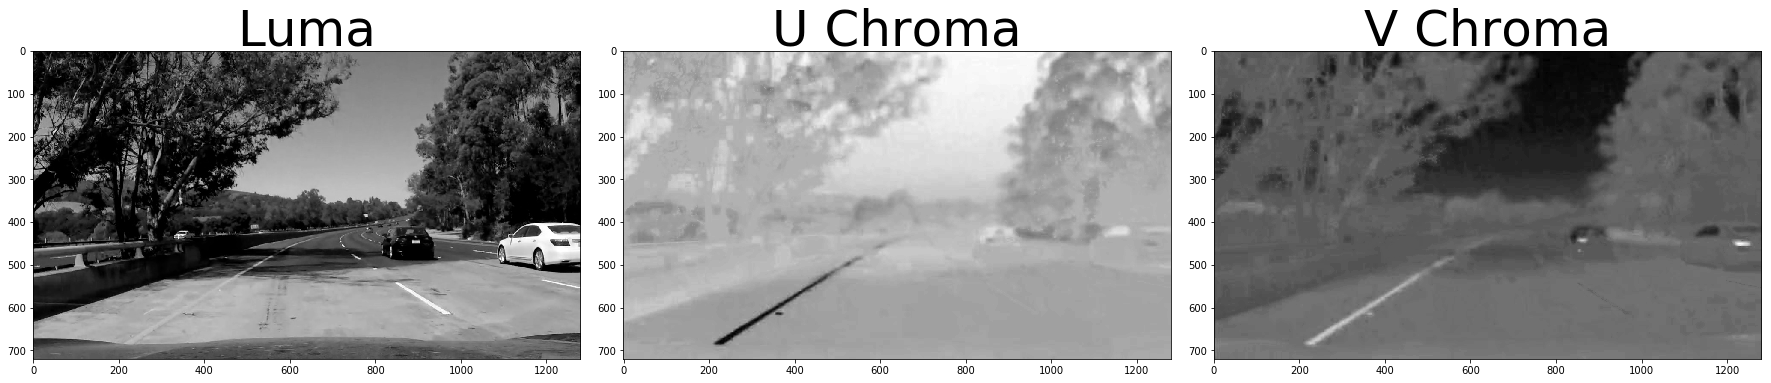

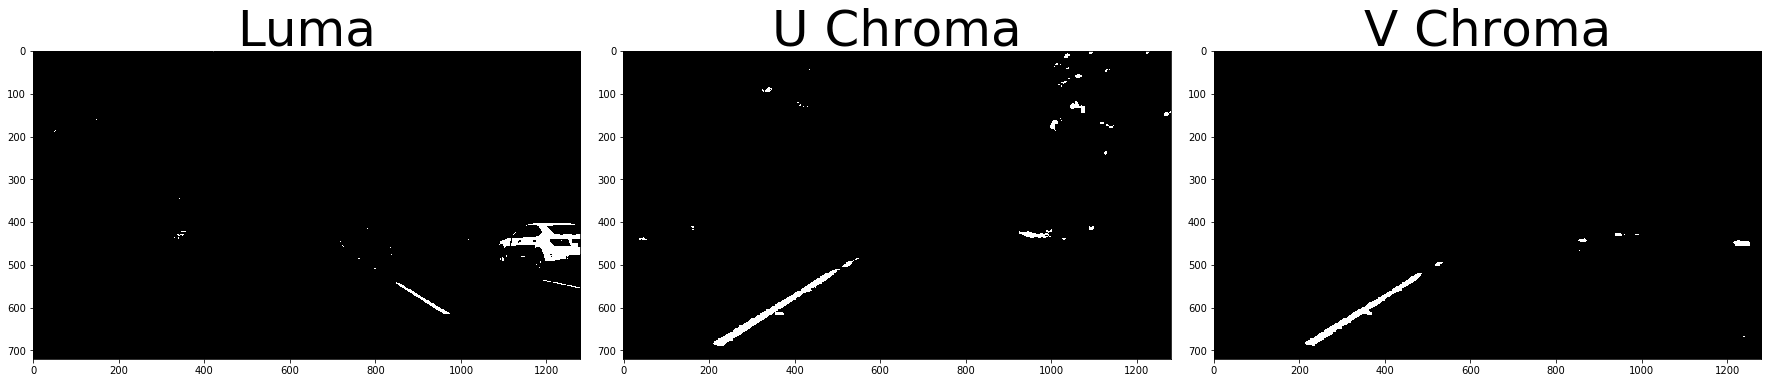

In [127]:
'''
YUV Thresholding
'''

yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
Y, U, V = cv2.split(yuv)

channel_labels = ("Luma", "U Chroma", "V Chroma")

display_three_channels((Y, U, V), channel_labels)

thresh = (220, 255)
Y = thresh_mask(Y, thresh)

thresh = (50, 110)
U = thresh_mask(U, thresh)

thresh = (150, 255)
V = thresh_mask(V, thresh)

display_three_channels((Y, U, V), channel_labels)

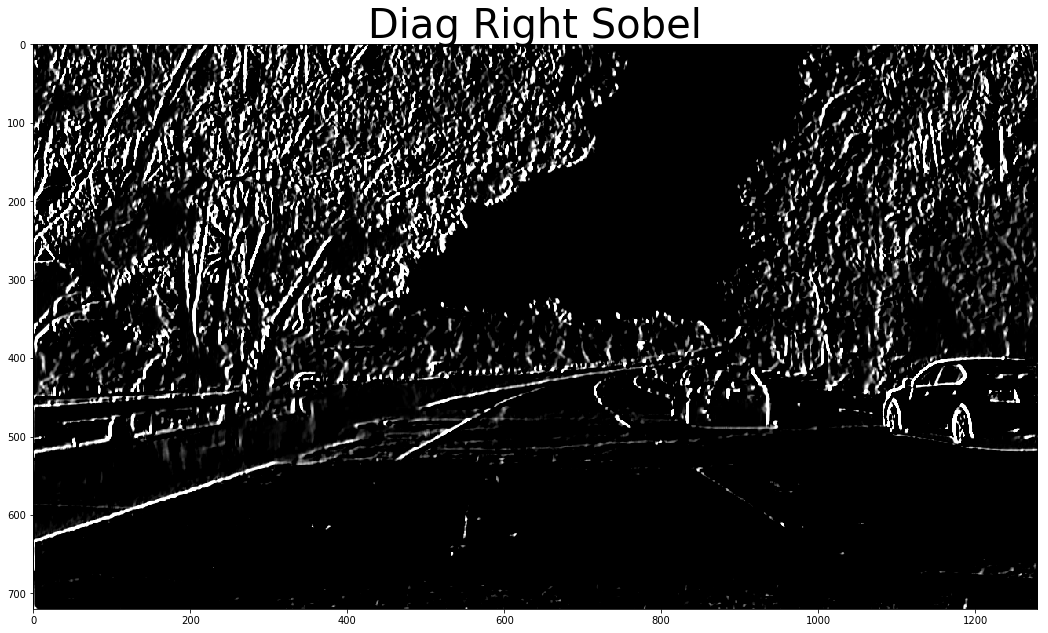

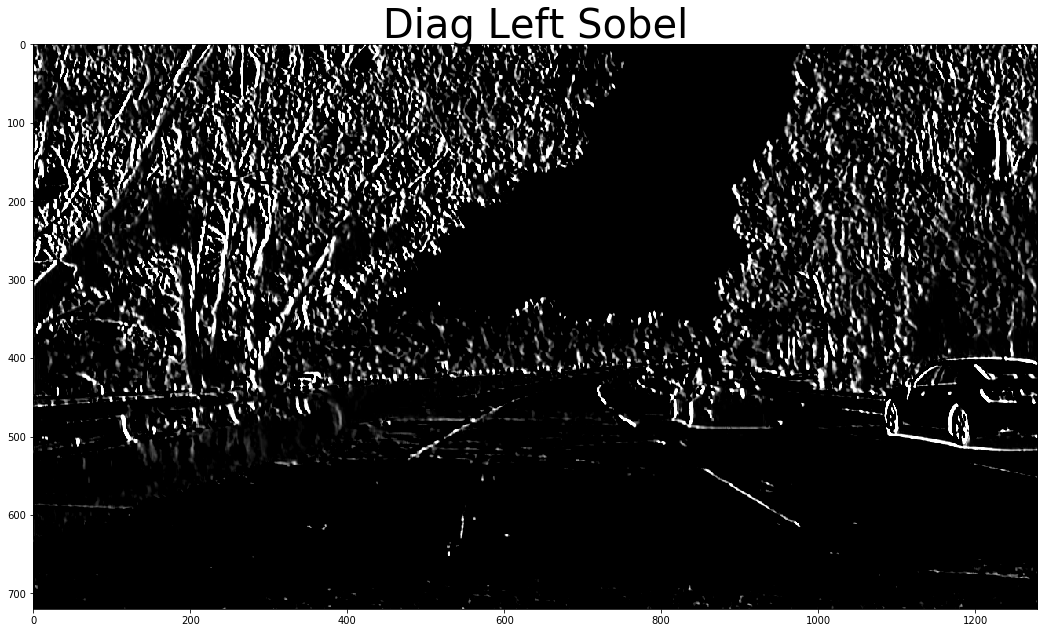

In [163]:
'''
Conv filters
'''
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# construct the Sobel x-axis kernel
sobelX = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int")
 
# construct the Sobel y-axis kernel
sobelY = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int")

# construct the Sobel x-axis kernel
sobelXL = np.array((
    [-1, 0, 0, 0, 1],
    [-2, 0, 0, 0, 2],
    [-2, 0, 0, 0, 2],
    [-1, 0, 0, 0, 1],
    [-1, 0, 0, 0, 1]), dtype="int")

# construct the Sobel x-axis kernel - diagonal right
sobelDR = np.array((
    [-1, -1, 0, 0, 1],
    [-2, -1, 0, 0, 2],
    [-2, -1, 0, 0, 2],
    [-1, 0, 0, 0, 2],
    [-1, 0, 0, 1, 1]), dtype="int")

#strong diagonal right
sobelSDR = np.array(( 
    [-3, -2, -1, 0, 0],
    [-2, -1, 0, 0, 2],
    [-2, -1, 0, 0, 2],
    [-1, 0, 0, 0, 2],
    [0, 0, 0, 1, 2]), dtype="int")

sobelDL = np.fliplr(sobelDR)

kernel = sobelDR

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
opencvOutput = cv2.filter2D(gray, -1, kernel)

fig=plt.figure(figsize=(18, 16))
plt.imshow(opencvOutput, cmap="gray")
plt.title("Diag Right Sobel", size=40)
plt.show()

kernel = sobelDL

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
opencvOutput = cv2.filter2D(gray, -1, kernel)

fig=plt.figure(figsize=(18, 16))
plt.imshow(opencvOutput, cmap="gray")
plt.title("Diag Left Sobel", size=40)
plt.show()


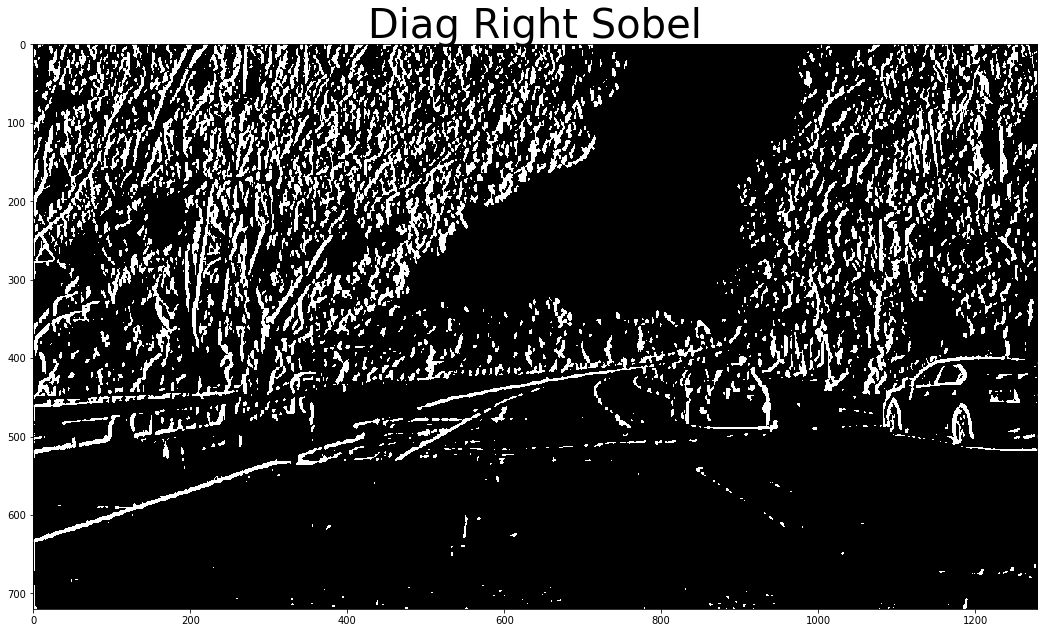

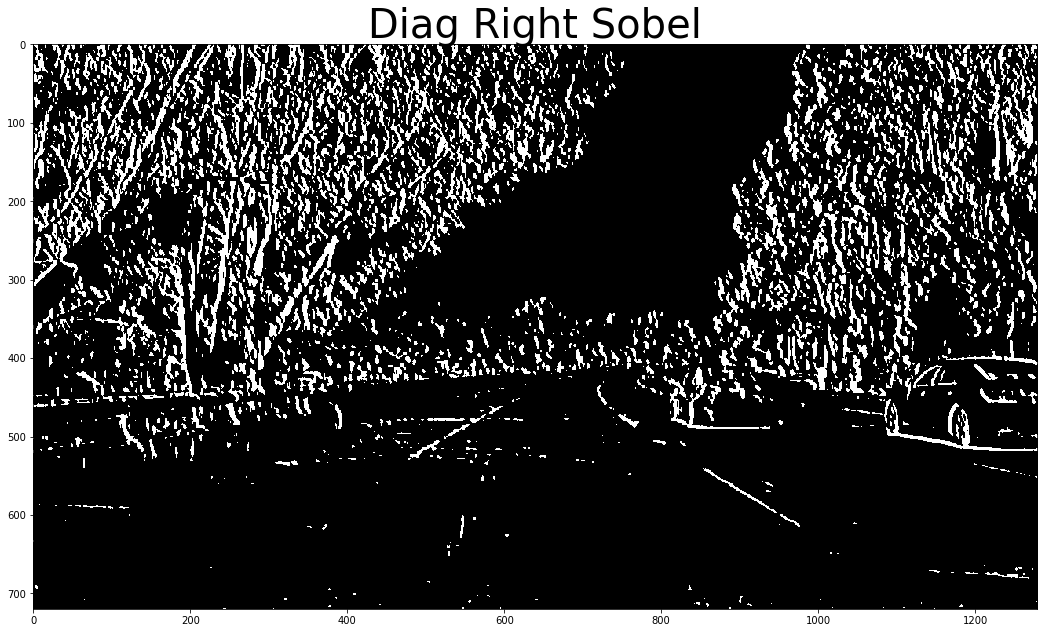

In [169]:
def sobel_masks(img):
    # construct the Sobel x-axis kernel - diagonal right
    sobelDR = np.array((
        [-1, -1, 0, 0, 1],
        [-2, -1, 0, 0, 2],
        [-2, -1, 0, 0, 2],
        [-1, 0, 0, 0, 2],
        [-1, 0, 0, 1, 1]), dtype="int")
    
    sobelDL = np.fliplr(sobelDR)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    diagR = cv2.filter2D(gray, -1, sobelDR)
    diagL = cv2.filter2D(gray, -1, sobelDL)
    
    thresh = (50, 255)
    diagRth = thresh_mask(diagR, thresh, val=0.05)
    
    thresh = (50, 255)
    diagLth = thresh_mask(diagL, thresh, val=0.05)
    
    return diagRth, diagLth

DR, DL = sobel_masks(img)

fig=plt.figure(figsize=(18, 16))
plt.imshow(DR, cmap="gray")
plt.title("Diag Right Sobel", size=40)
plt.show()

fig=plt.figure(figsize=(18, 16))
plt.imshow(DL, cmap="gray")
plt.title("Diag Right Sobel", size=40)
plt.show()


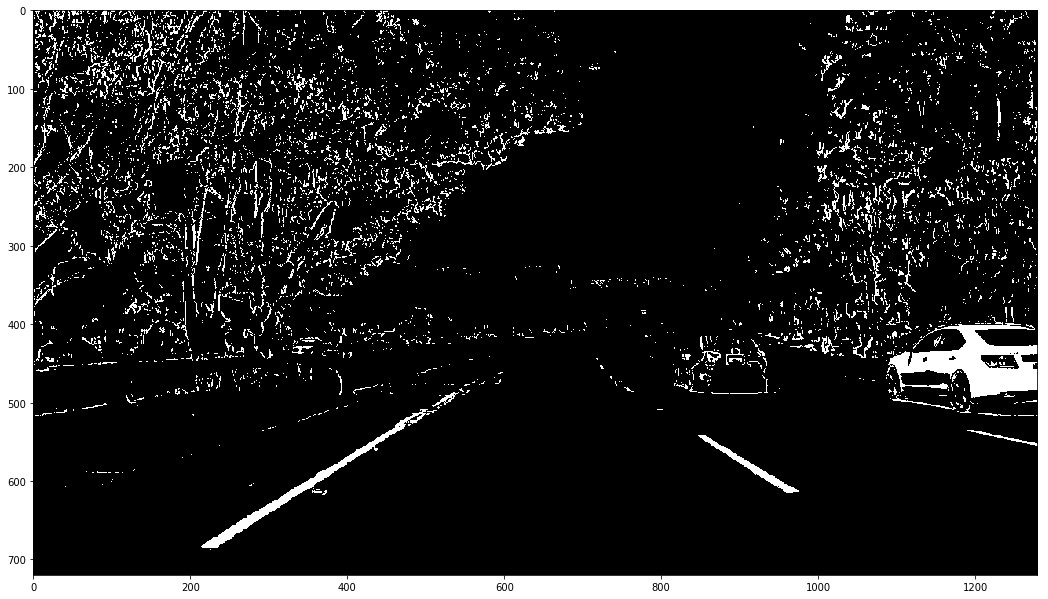

In [174]:
'''
combine some masks
'''
def combine_masks(S, U, V, R, G, B, DR, DL, thresh=0.1):    
    combined = np.zeros_like(S, dtype=np.uint8)
    #combined[(S == 1) | (U == 1) | (R == 1) | (G == 1) | (B == 1)] = 1
    combined[(S + U + R + G + B + DR + DL) > thresh] = 1
    return combined

combined = combine_masks(S, U, V, R, G, B, DL, DR)
fig=plt.figure(figsize=(18, 16))
plt.imshow(combined, cmap="gray")
plt.show()

In [100]:
import math

'''
mask a polygon of the image
'''

def make_mask(img_size, #width, height tuple
              horizon_perc, # the upper threshold, as a percent of height
              bottom_perc, #the lower thresh, as a percent of height
              mask_bottom_perc = 1.0, #the lower percent of width
              mask_top_perc = 0.5): #the upper percent of width
    img_width = img_size[0]
    img_height = img_size[1]
    
    centerX = img_width / 2
    
    horizon_y = math.floor(horizon_perc * img_height)
    bottom_y_margin = math.floor(bottom_perc * img_height)
    bottom = img_height - bottom_y_margin
    top = horizon_y
    
    mask_bottom_left_x   = math.floor(centerX - img_width * (mask_bottom_perc * 0.5))
    mask_bottom_right_x  = math.floor(centerX + img_width * (mask_bottom_perc * 0.5))
    mask_top_left_x      = math.floor(centerX - img_width * (mask_top_perc * 0.5))
    mask_top_right_x     = math.floor(centerX + img_width * (mask_top_perc * 0.5))

    mask_points = [(mask_bottom_left_x,  bottom),
                   (mask_top_left_x,     top),
                   (mask_top_right_x,    top), 
                   (mask_bottom_right_x, bottom)]
    
    return mask_points

def apply_mask(img, mask_points):
    ignore_mask_color = 255
    mask = np.zeros_like(img)
    vertices =  np.array([mask_points], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    result = cv2.bitwise_and(img, mask)
    return result


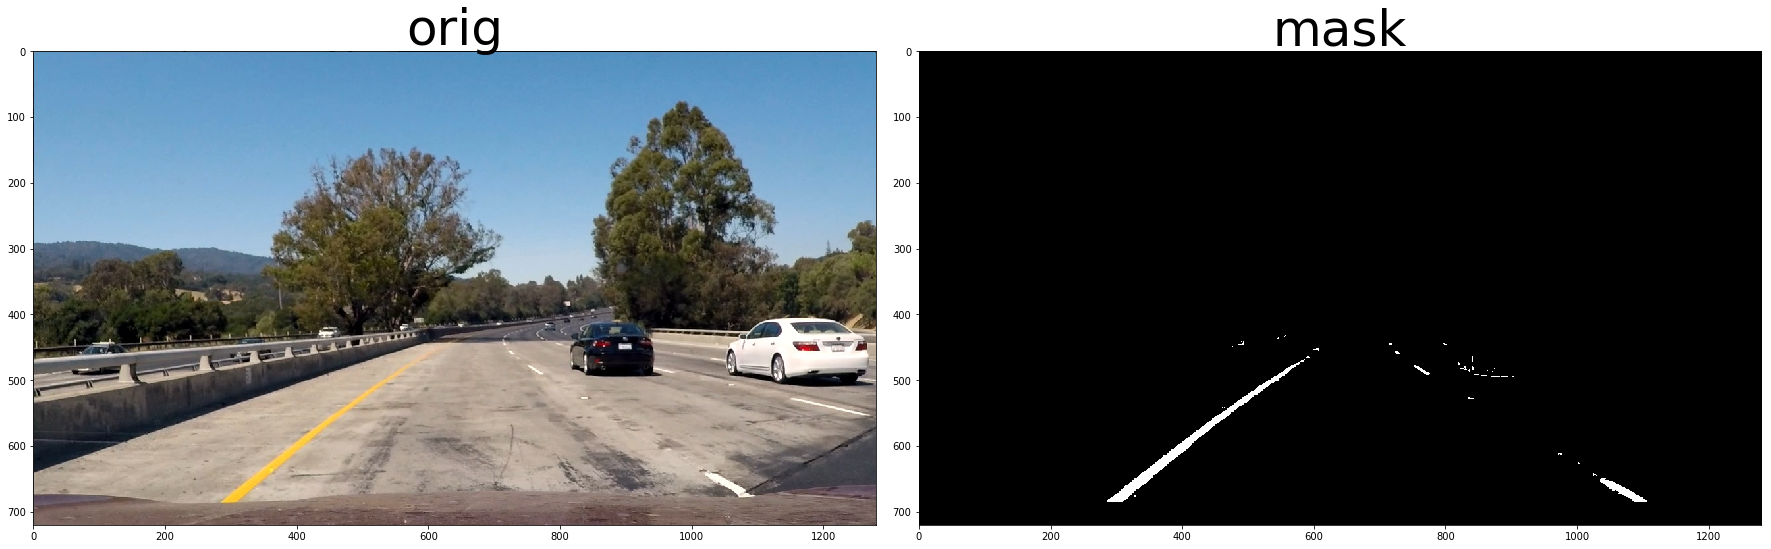

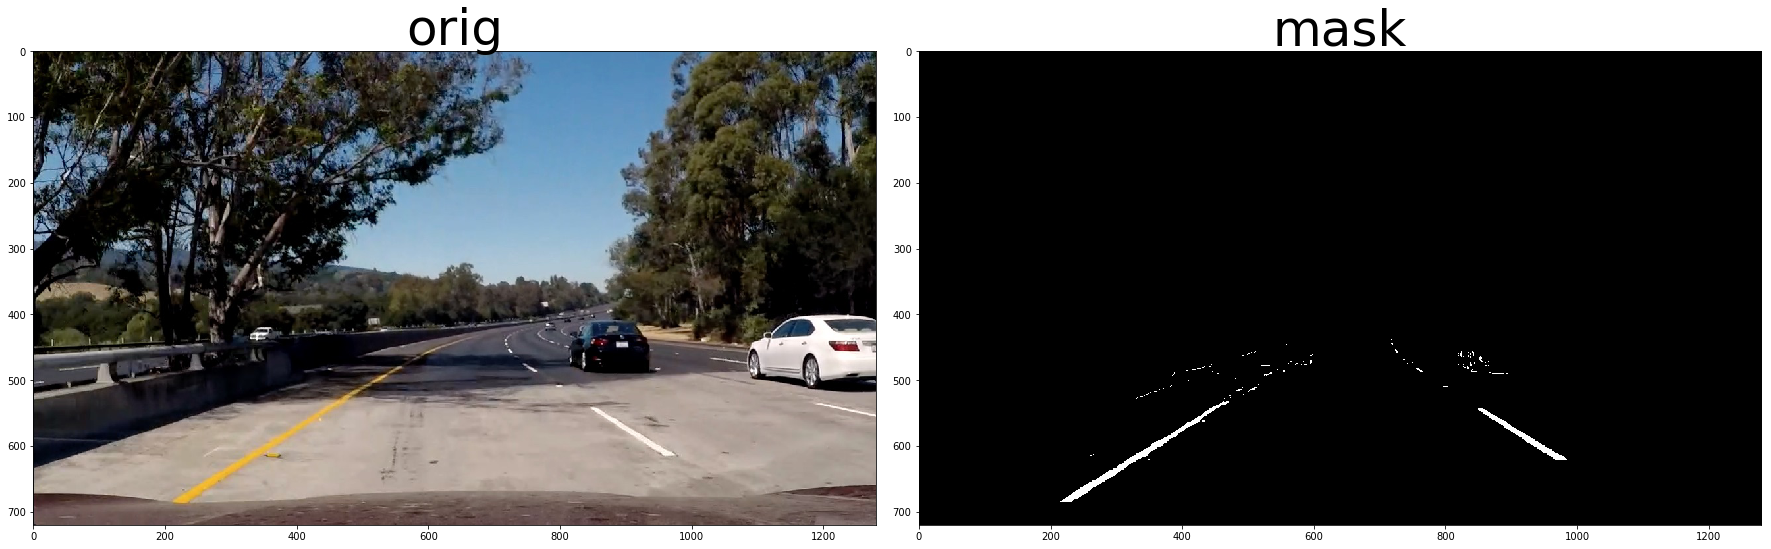

In [175]:
def color_thresold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H, L, S = cv2.split(hls)
    
    thresh = (150, 255)
    S = thresh_mask(S, thresh)

    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    R, G, B = cv2.split(rgb)

    thresh = (200, 255)
    R = thresh_mask(R, thresh)

    thresh = (200, 255)
    G = thresh_mask(G, thresh)

    thresh = (220, 255)
    B = thresh_mask(B, thresh)
    
    yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    Y, U, V = cv2.split(yuv)

    thresh = (50, 100)
    U = thresh_mask(U, thresh)
    
    thresh = (150, 255)
    V = thresh_mask(V, thresh)
    
    DR, DL = sobel_masks(img)
    
    return combine_masks(S, U, V, R, G, B, DL, DR)

def display_n_images(images, labels, cmaps):
    n = len(images)
    f, subplt = plt.subplots(1, n, figsize=(24, 9))
    f.tight_layout()
    for i in range(n):
        subplt[i].imshow(images[i], cmap=cmaps[i])
        subplt[i].set_title(labels[i], fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
#files = glob.glob('test_images/test*.jpg')
files = ['test_images/test1.jpg', 'test_images/test5.jpg']

masks = []

for infile in files:
    img = cv2.imread(infile)
    img_size = (img.shape[1], img.shape[0])
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    '''
    correct for camera distortion
    '''
    undistorted = undistort(rgb, mtx, dist)
    
    '''
    use HLS and RGB color thresholding
    '''
    combined = color_thresold(undistorted)
    
    '''
    make and apply polygon mask
    '''
    mask_points = make_mask(img_size, 0.6, 0.05, 0.9, 0.25)
    combined = apply_mask(combined, mask_points)
    
    display_n_images((rgb, combined), ("orig", "mask"), (None, "gray"))
    
    masks.append(combined)
    

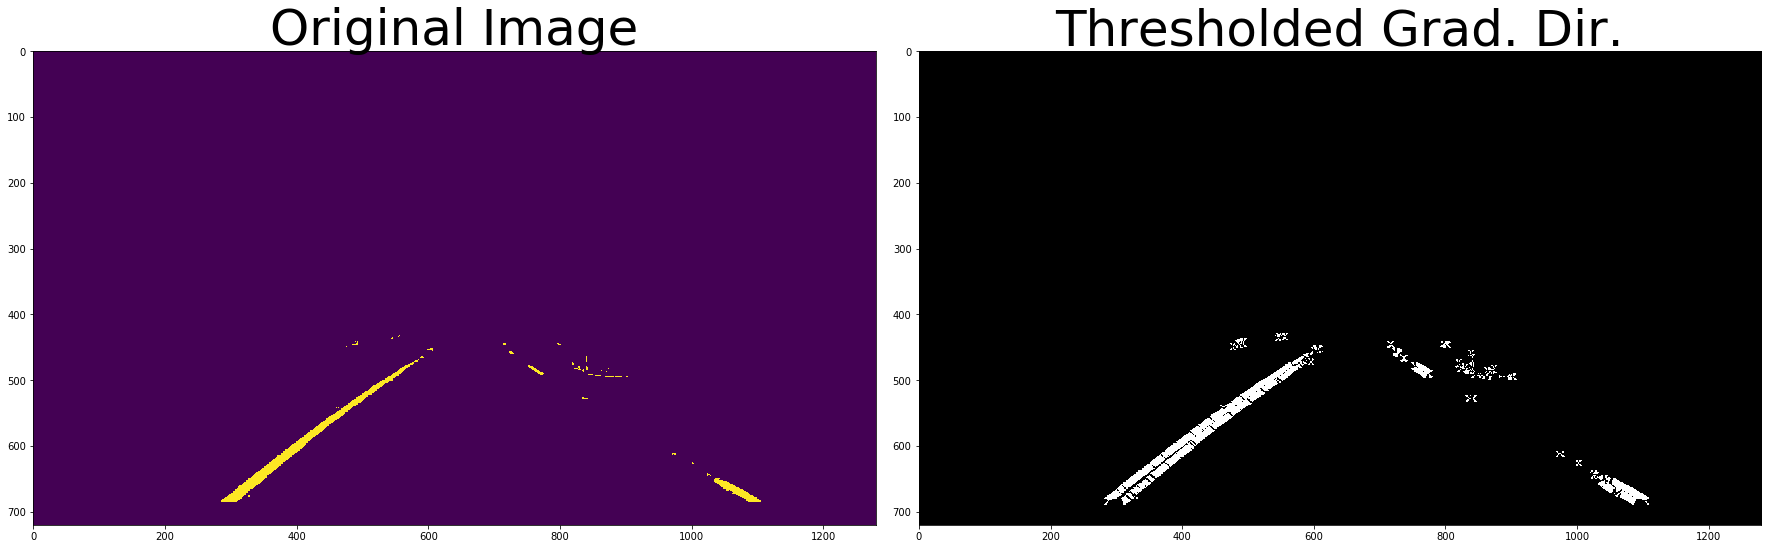

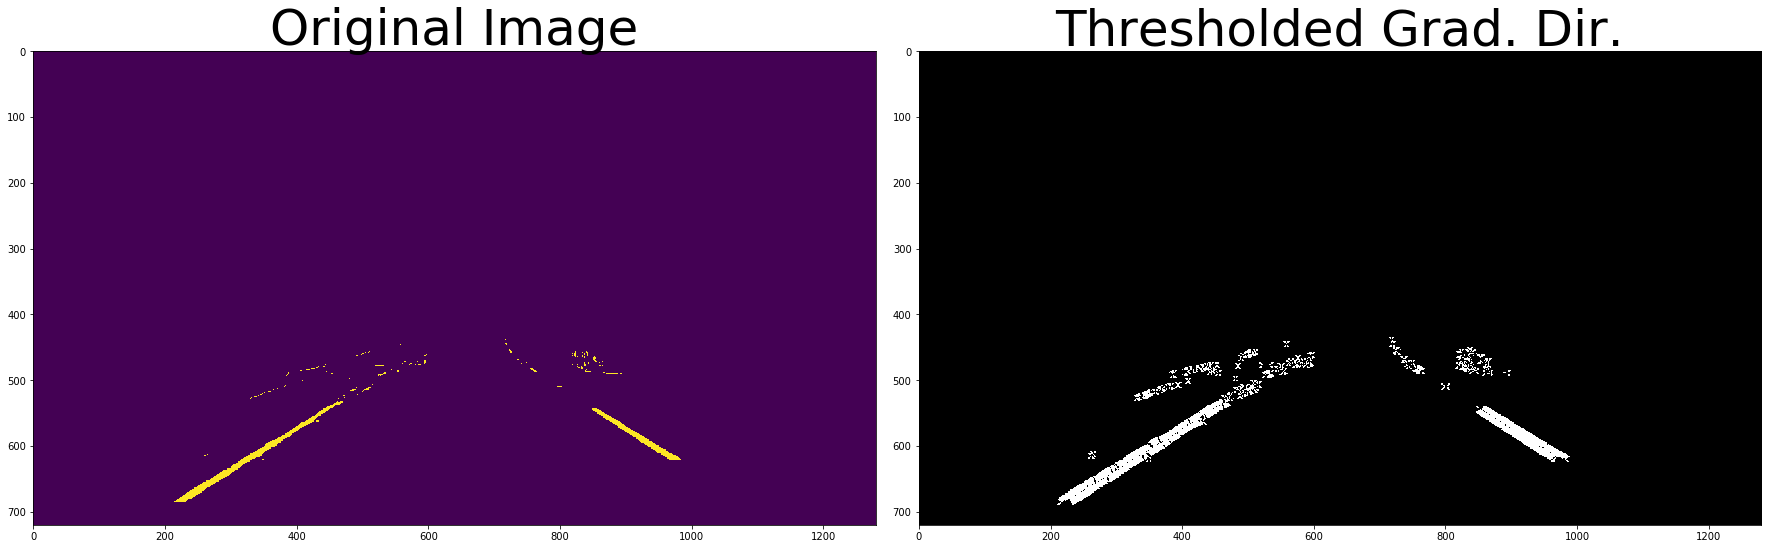

In [176]:
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output
    
# Run the function
for image in masks:
    dir_binary = dir_threshold(image, sobel_kernel=9, thresh=(0.7, 1.3))
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dir_binary, cmap='gray')
    ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

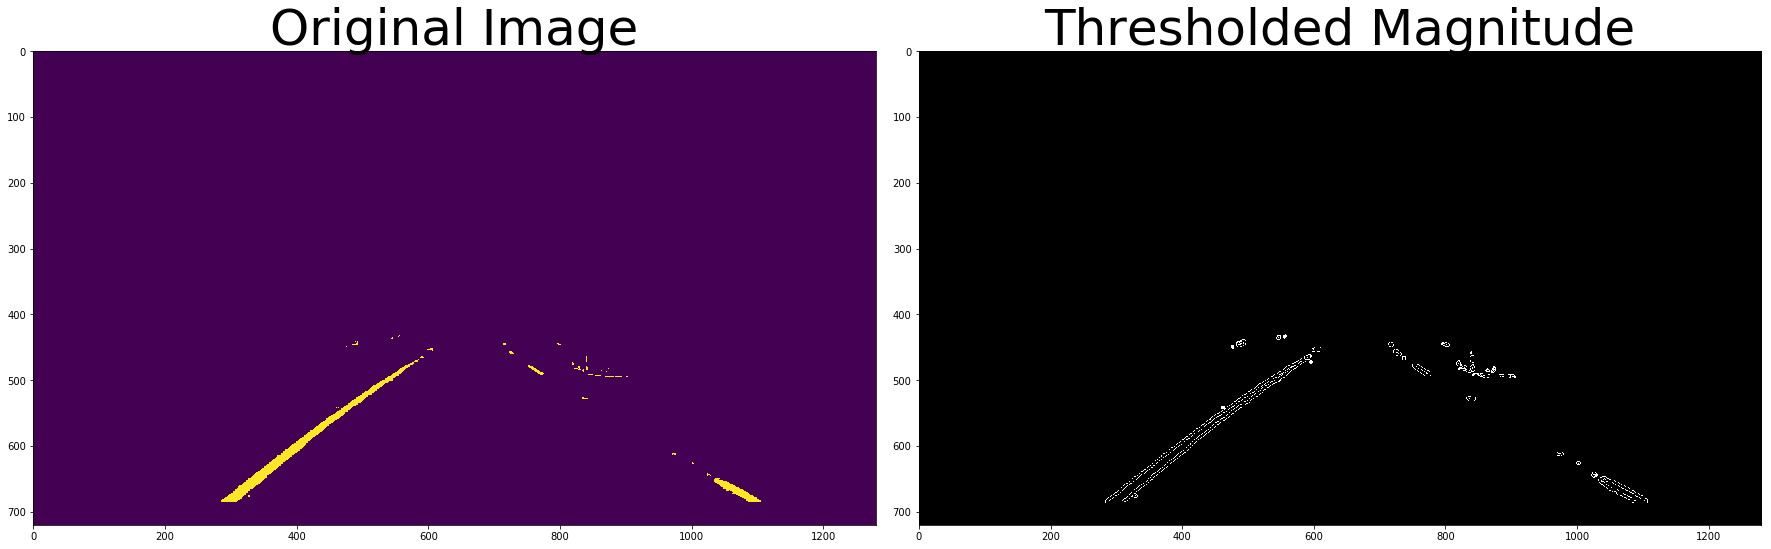

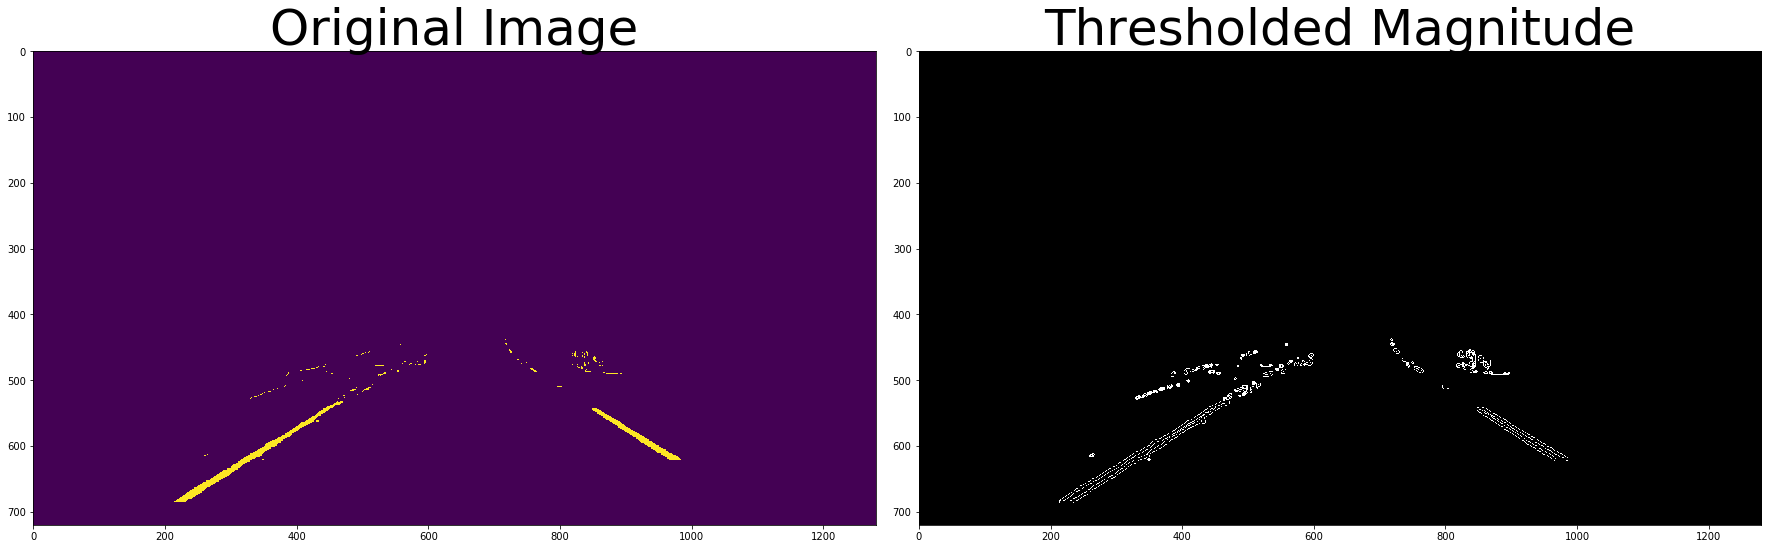

In [177]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output
    
for image in masks:
    mag_binary = mag_thresh(image, sobel_kernel=7, mag_thresh=(30, 100))
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(mag_binary, cmap='gray')
    ax2.set_title('Thresholded Magnitude', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


lines found: 84


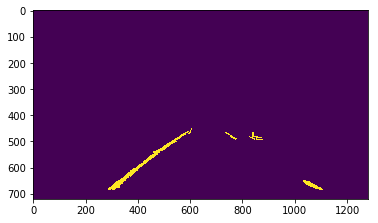

lines found: 57


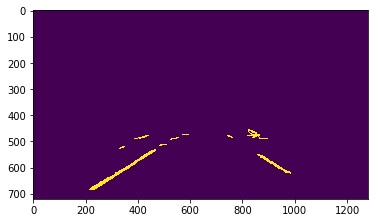

In [191]:
def get_lines(img):
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
        
    #lines = cv2.HoughLinesP(img,rho = 1,theta = 1*np.pi/180,threshold = 1, minLineLength = 1, maxLineGap = 10)      
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    return lines

for image in masks:
    lines = get_lines(image)
    print("lines found:", len(lines))
    line_image = np.copy(image)*0
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(line_image,(x1,y1),(x2,y2),(255,64,64),3)
    plt.imshow(line_image)
    plt.show()


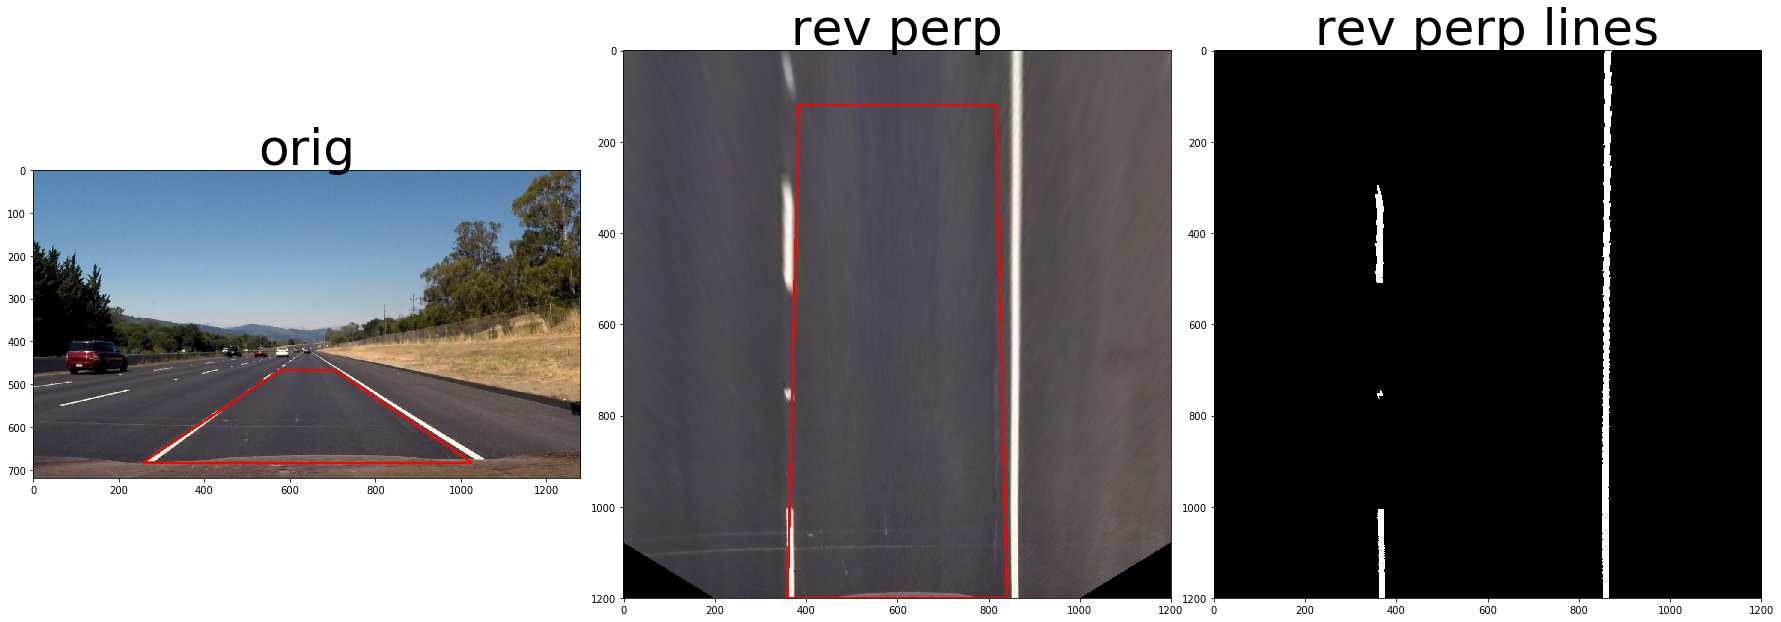

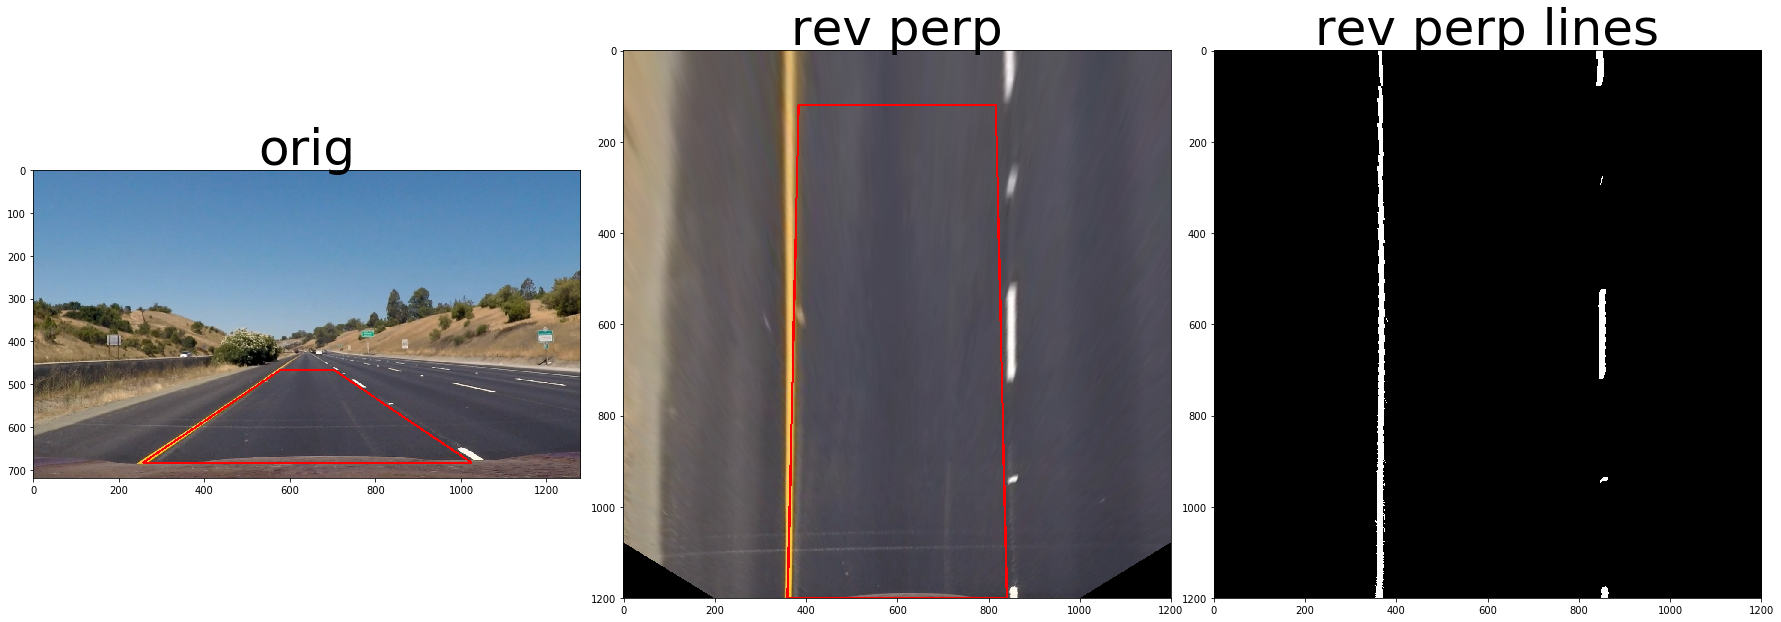

In [195]:
def perspective_reverse(img, corners_src, corners_dest, img_size):
    '''
    take and image and four src points in a rhombus along the lane lines
    dest points in a more linear quad, warp image to straighten effects
    of perspective transformation.
    '''
    
    src = np.float32(corners_src)
    
    dst = np.float32(corners_dest)
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    invM = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, invM

def draw_lines(img, corners, color, line_w):
    n = len(corners)
    for i in range(n):
        iS = i
        iE = (i + 1) % n
        a = corners[iS]
        b = corners[iE]
        cv2.line(img, a, b, color, line_w)
        
        
def undist_thresh_rev_proj(img, debug=False):
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1], img.shape[0])
    warped_size = (1200, 1200)

    
    '''
    correct for camera distortion
    '''
    undistorted = undistort(rgb, mtx, dist)
    
    '''
    use HLS and RGB color thresholding
    '''
    combined = color_thresold(undistorted)
    
    '''
    make and apply polygon mask
    '''
    mask_points = make_mask(img_size, 0.6, 0.05, 0.9, 0.25)
    combined = apply_mask(combined, mask_points)
    
    src_cn = make_mask(img_size, 0.65, 0.05, 0.60, 0.1)
    dest_cn = make_mask(warped_size, 0.1, 0.0, 0.4, 0.36)
    
    #warped = combined
    warped, M, invM = perspective_reverse(combined, src_cn, dest_cn, warped_size)
    warped_color, M, invM = perspective_reverse(undistorted, src_cn, dest_cn, warped_size)
    
    if debug:
        draw_lines(rgb, src_cn, (255, 0, 0), 3)
        draw_lines(warped_color, dest_cn, (255), 3)

        display_n_images((rgb, warped_color, warped), 
                         ("orig", "rev perp", "rev perp lines"), 
                         (None, None, "gray"))
    return warped, M, invM 


files = glob.glob('test_images/straight*.jpg')

for infile in files:
    img = cv2.imread(infile)
    undist_thresh_rev_proj(img, True)

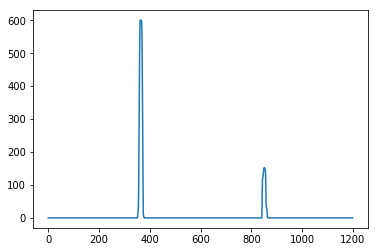

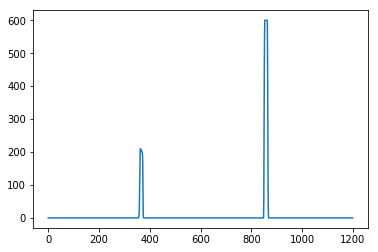

In [213]:
infile = 'test_images/straight_lines1.jpg'

img = cv2.imread(infile)
img, M, invM = undist_thresh_rev_proj(img, False)

histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

infile = 'test_images/straight_lines2.jpg'

img = cv2.imread(infile)
img, M, invM = undist_thresh_rev_proj(img, False)

histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

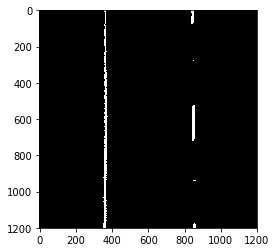

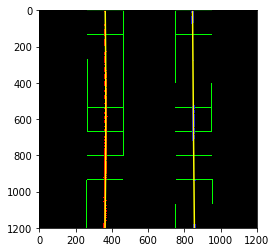

In [286]:
def walk_lines(binary_warped, prevLeftXBase = None, prevRightXBase=None):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img

def bin_thresh_img(img, thresh):
    binary_img = np.zeros_like(img)
    binary_img[(img >= thresh)] = 1
    return binary_img

def plot_lane_walk(binary_warped, left_fit, right_fit, out_img):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    h, w, ch = out_img.shape

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, w)
    plt.ylim(h, 0)


infile = 'test_images/test6.jpg'
infile = 'test_images/straight_lines1.jpg'

img = cv2.imread(infile)
warped, M, invM = undist_thresh_rev_proj(img, False)
binary_warped = bin_thresh_img(warped, 1)

plt.imshow(binary_warped, cmap="gray")
plt.show()

left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = walk_lines(binary_warped)

plot_lane_walk(binary_warped, left_fit, right_fit, out_img)

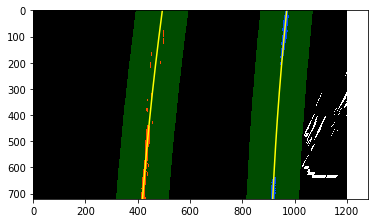

In [244]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def update_walk_lines(binary_warped, left_fit, right_fit, debug=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if debug:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

update_walk_lines(binary_warped, left_fit, right_fit, debug=True)

In [265]:
def sample_curve(coeff, val):
    return coeff[0]*val**2 + coeff[1]*val + coeff[2]

h, w = binary_warped.shape

#sample curve at bottom of image, which is max h
leftX = sample_curve(left_fit, h)
print(leftX)

rightX = sample_curve(right_fit, h)
print(rightX)

389.775731548
903.589118859


In [287]:

def get_pixel_to_m(left_lane_x, right_lane_x, img):
    '''
    get the scale of pixel in world space (meters)
    '''
    h, w = img.shape
    
    # Define conversions in x and y from pixels space to meters
    pixel_lane_width = right_lane_x - left_lane_x
    meters_lane_width = 3.7    
    
    # meters per pixel in x dimension
    xm_per_pix = meters_lane_width / pixel_lane_width
    
    # meters per pixel in y dimension
    ym_per_pix = 30.0 /  h
    
    return xm_per_pix, ym_per_pix


def sample_curves_to_points(left_fit, right_fit, out_img):
    '''
    sample the points of two y paramatized curves in an image
    returns:
        ploty, the array of y values
        leftX, the array of x values sampled from left_fit curve
        rightX, the array of x values sampled from right_fit curve    
    '''
    h, w = out_img.shape
    
    #sample curve
    ploty = np.linspace(0, h-1, num=h)
    leftX = []
    rightX = []
    
    for val in range(0, h):
        lX = sample_curve(left_fit, val)
        rX = sample_curve(right_fit, val)
        leftX.append(lX)
        rightX.append(rX)
        
    leftX = np.array(leftX)
    rightX = np.array(rightX)
    return ploty, leftX, rightX


def get_world_space_rad_curve_m(left_fit, right_fit, out_img):
    '''
    get the radius of curvature in world space (meters)
    '''
    h, w = out_img.shape
    
    print(w, h)
    
    #sample curve
    ploty, leftX, rightX = sample_curves_to_points(left_fit, right_fit, out_img)

    xm_per_pix, ym_per_pix = get_pixel_to_m(leftX[-1], rightX[-1], out_img)

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = h
    
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftX*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightX*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad




lrad, rrad = get_world_space_rad_curve_m(left_fit, right_fit, binary_warped)

print("left lane radius(m): %f right lane radius(m): %f" % (lrad, rrad))

avg_rad = (lrad + rrad) / 2.0

print("avg radius(m):", avg_rad)


1200 1200
left lane radius(m): 4012.492296 right lane radius(m): 35590.152882
avg radius(m): 19801.3225892


In [282]:
def unwarp_lines(warped, left_fit, right_fit, Minv):
    
    #sample the curves for points
    ploty, left_fitx, right_fitx = sample_curves_to_points(left_fit, right_fit, warped)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    h, w = warped.shape
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    return newwarp



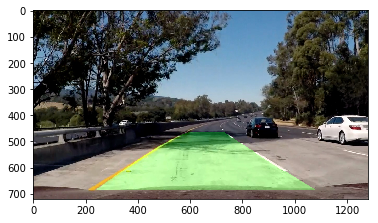

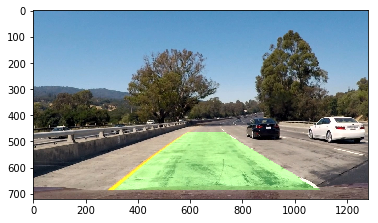

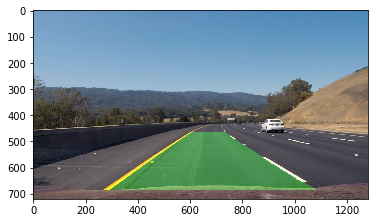

In [284]:
files = glob.glob('test_images/test*.jpg')[:3]

for infile in files:
    img = cv2.imread(infile)
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    warped, M, invM = undist_thresh_rev_proj(img, False)

    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = walk_lines(warped)

    newwarp = unwarp_lines(warped, left_fit, right_fit, invM)
    
    # Combine the result with the original image
    result = cv2.addWeighted(rgb, 1, newwarp, 0.3, 0)
    plt.imshow(result)    
    plt.show()
